In [ ]:
# Librairies
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

from scipy.stats import norm

import joblib
import matplotlib.dates as mdates
from google.colab import files

import json

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
import random
import os

# Set seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If you are using CUDA
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
#NSE, RMSE, KGE
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def kge(obs, sim):
    """Kling-Gupta Efficiency (KGE)"""
    obs, sim = np.array(obs), np.array(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    beta = np.mean(sim) / np.mean(obs)
    gamma = (np.std(sim) / np.mean(sim)) / (np.std(obs) / np.mean(obs))

    return 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)

In [ ]:
# Import data
from google.colab import drive
drive.mount('/content/drive')

daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Bonou/calage_biao.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Calibration data
discharge = daily.iloc[:1461, 0].to_numpy()
prec = daily.iloc[:1461, 1].to_numpy()
pet = daily.iloc[:1461, 2].to_numpy()

#Compute the Effective precipitation
prec_eff = prec - pet
prec_eff[prec_eff < 0] = 0


In [ ]:
#Estimates of the HyMoLAP
MU = 0.8001196845564451
LAMBDA = 8.242717863862458

In [ ]:
#X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

#X(t)
X = state_basin(MU, LAMBDA, prec_eff)

Multi-step  

..... t+7

Calibration phase

In [ ]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 8):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S7 = np.zeros(len(discharge))
S7[0] = discharge[0]

for k in range(0, len(discharge)-5, 7):
    (S7[k+1], S7[k+2], S7[k+3], S7[k+4], S7[k+5], S7[k+6], S7[k+7]) = \
        compute_Q(discharge[k], X[k]*prec_eff[k], MU, LAMBDA)


In [ ]:
S7[-5], S7[-4]

(53.862090775725434, 0.0)

In [ ]:
psi = X[-5]*prec_eff[-5]
S7[-4] = discharge[-5] +  (- (MU / LAMBDA) * discharge[-5]**(2 * MU - 1) + (1 / LAMBDA) * psi)

for i in range(-3, 0):
    S7[i] = 2 * S7[i - 1] - S7[i - 2]

In [ ]:
nse_value = nash_sutcliffe_efficiency(discharge[1:], S7[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge[1:], S7[1:]))

print('kge=',kge(discharge[1:], S7[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.9672754116905631
rmse= 48.787441283099895
kge= 0.9811334058816082


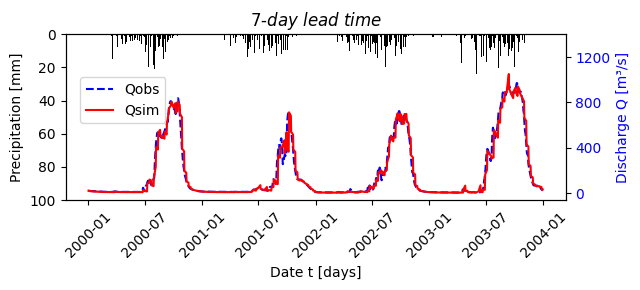

In [ ]:
# Define the date range
time1 = np.datetime64('2000-01-02')  # Start date
time2 = np.datetime64('2003-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create the figure and axes with an adjusted size
fig, ax1 = plt.subplots(figsize=(6.5, 3))

# Plot the precipitation histogram on ax1
ax1.bar(time, prec[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Configure the y-axis for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis to display precipitation in reverse order
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis for discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge[1:], 'b--', label='Qobs')

# Plot the prediction
ax2.plot(time, S7[1:], 'r', label='Qsim')

# Configure the y-axis for discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Add a legend
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.75))

# Adjust the layout to avoid overlapping elements
plt.tight_layout()

# Display the plot
plt.show()


Validation

In [ ]:
# Validation data
discharge1 = daily.iloc[1461:, 0].to_numpy()
prec1 = daily.iloc[1461:, 1].to_numpy()
pet1 = daily.iloc[1461:, 2].to_numpy()

#Compute the Effective precipitation
prec_eff1 = prec1 - pet1
prec_eff1[prec_eff1 < 0] = 0

#X(t)
X = state_basin(MU, LAMBDA, prec_eff1)

In [ ]:
#Simulation
def compute_Q(Q_t, psi_t, mu, lambda_):
    Q_values = []
    for i in range(1, 8):
      if i==1:
        Q_next = Q_t +  (- (mu / lambda_) * Q_t**(2 * mu - 1) + (1 / lambda_) * psi_t)
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next
      else:
        Q_next = 2*Q_t-Q_prec
        Q_values.append(Q_next)
        Q_prec = Q_t
        Q_t = Q_next

    return tuple(Q_values)

S71 = np.zeros(len(discharge1))
S71[0] = discharge1[0]

for k in range(0, len(discharge1)-3, 7):
    (S71[k+1], S71[k+2], S71[k+3], S71[k+4], S71[k+5], S71[k+6], S71[k+7]) = \
        compute_Q(discharge1[k], X[k]*prec_eff1[k], MU, LAMBDA)

In [ ]:
S71[-3], S71[-2]

(18.484830349154873, 0.0)

In [ ]:
psi = X[-3]*prec_eff1[-3]
S71[-2] = discharge1[-3] +  (- (MU / LAMBDA) * discharge1[-3]**(2 * MU - 1) + (1 / LAMBDA) * psi)

S71[-1] = 2*S71[-2] - S71[-3]

In [ ]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], S71[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], S71[1:]))

print('kge=',kge(discharge1[1:], S71[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.9548429667739058
rmse= 45.895073081653564
kge= 0.9766946404874096


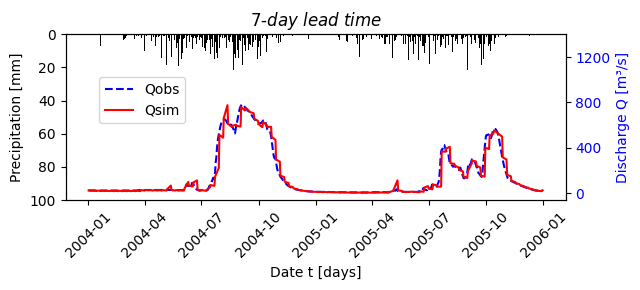

In [ ]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='99% CrI')

# Plot the prediction
ax2.plot(time, S71[1:], 'r', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.75))

# Display the grid
#plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Display the plot
plt.show()


Hybrid HyMoLAP-Bayesian LSTM

# Prepare Training Data

In [ ]:
# Creating the DataFrame for training (calibration)
data_train = pd.DataFrame({
        'HyMoLAP': S7[1:],
        'target': discharge[1:]
})

# Creating the DataFrame for validation (test)
data_test = pd.DataFrame({
        'HyMoLAP': S71[1:],
        'target': discharge1[1:]
})

# Splitting features and target
train_X, train_y = data_train.iloc[:, :-1], data_train.iloc[:, -1]  # Features and target for training
test_X, test_y = data_test.iloc[:, :-1], data_test.iloc[:, -1]      # Features and target for testing

# Normalizing features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_train_X = scaler_X.fit_transform(train_X.values.astype('float32'))
scaled_test_X = scaler_X.transform(test_X.values.astype('float32'))  # Use transform() for test set

# Normalizing the target variable
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_train_y = scaler_y.fit_transform(train_y.values.reshape(-1, 1).astype('float32')).flatten()
scaled_test_y = scaler_y.transform(test_y.values.reshape(-1, 1).astype('float32')).flatten()

# Define Bayesian LSTM Architecture

We demonstrate a simple working example of the Bayesian LSTM considering the 7-day lead time. The network architecture is as follows:

Encoder-Decoder Stage:
 - A uni-directional LSTM with 2 stacked layers & 64 hidden units acting as an encoding layer to construct a fixed-dimension embedding state
 - A uni-directional LSTM with 2 stacked layers & 128 hidden units acting as a decoding layer to produce predictions at future steps
 - Dropout is applied at **both** training and inference for both LSTM layers

 Predictor Stage:
 - 1 fully-connected output layer with 1 output (for predicting the target value) to produce a single value for the target variable


During inference, multiple stochastic forward passes are performed to generate prediction intervals, effectively capturing uncertainty in multi-step ahead streI amflow forecasts.


In [ ]:
class BayesianLSTM(nn.Module):

    def __init__(self, n_features, output_length, batch_size):

        super(BayesianLSTM, self).__init__()

        self.batch_size = batch_size # defined below

        self.hidden_size_1 = 64 # number of encoder cells
        self.hidden_size_2 = 128 # number of decoder cells
        self.stacked_layers = 2 # number of (stacked) LSTM layers for each stage
        self.dropout_probability = 0.5 # chosen value for ensuring stability and accuracy
        self.lstm1 = nn.LSTM(n_features,
                             self.hidden_size_1,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)

        self.fc = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)
        output, _ = self.lstm1(x, hidden)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output = output[:, -1, :] # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred

    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state

    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state

    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

### Begin Training

To train the Bayesian LSTM, we use the ADAM optimizer along with mini-batch gradient descent (`batch_size = 128`).

In [ ]:
n_features = 1
sequence_length = 0
output_length = 1

batch_size = 128
n_epochs = 120
learning_rate = 0.01

bayesian_lstm = BayesianLSTM(n_features=n_features,
                             output_length=output_length,
                             batch_size = batch_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)



In [ ]:
bayesian_lstm.train()

for e in range(1, n_epochs+1):
    for b in range(0, len(scaled_train_X), batch_size):
        features = scaled_train_X[b:b+batch_size, :]
        target = scaled_train_y[b:b+batch_size]

        X_batch = torch.tensor(features, dtype=torch.float32).unsqueeze(1)  # [batch_size, 1, num_features]
        y_batch = torch.tensor(target,dtype=torch.float32)

        output = bayesian_lstm(X_batch)

        #Loss
        loss = criterion(output.view(-1), y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if e % 10 == 0:
        print('epoch', e, 'loss: ', loss.item())


epoch 10 loss:  0.0018506478518247604
epoch 20 loss:  0.0032286099158227444
epoch 30 loss:  0.0028129774145781994
epoch 40 loss:  0.004679636564105749
epoch 50 loss:  0.002355163684114814
epoch 60 loss:  0.005286189261823893
epoch 70 loss:  0.001921180635690689
epoch 80 loss:  0.002297409810125828
epoch 90 loss:  0.003934661857783794
epoch 100 loss:  0.0032349617686122656
epoch 110 loss:  0.003123902715742588
epoch 120 loss:  0.0025249810423702


# Uncertainty Quantification

In the Bayesian LSTM, MC dropouts are applied after each LSTM layer, allowing the model outputs to be interpreted as random samples from the posterior distribution of the target variable.

By running multiple predictions, we can estimate the parameters of this posterior distribution—specifically, the mean and variance—enabling the construction of credible intervals.

In this example, we generate 90% confidence intervals by setting the bounds three standard deviations away from the estimated mean of each prediction.

In [ ]:
# Function to inverse transform the scaled target values back to their original scale
def inverse_transform(y):
  return scaler_y.inverse_transform(y.reshape(-1, 1))

TRAINING PHASE

This is the step where we can also try to adjust the Bayesian model parameters in order to retain better model in terms of PICP and MPIW.

In [ ]:
#Multiple run
n_experiments = 1000

train_uncertainty_df = pd.DataFrame()


# Convert into 3D
scaled_train_X = torch.tensor(scaled_train_X, dtype=torch.float32).unsqueeze(1)

for i in range(n_experiments):
  experiment_predictions = bayesian_lstm.predict(scaled_train_X)
  train_uncertainty_df['Q_{}'.format(i)] = inverse_transform(experiment_predictions).flatten()

Q_df = train_uncertainty_df.filter(like='Q_', axis=1)
train_uncertainty_df['Q_mean'] = Q_df.mean(axis=1)
train_uncertainty_df['Q_std'] = Q_df.std(axis=1)

train_uncertainty_df = train_uncertainty_df[['Q_mean', 'Q_std']]

In [ ]:
#Build interval borns
train_uncertainty_df['lower_bound'] = train_uncertainty_df['Q_mean'] - 1.645*train_uncertainty_df['Q_std']
train_uncertainty_df['upper_bound'] = train_uncertainty_df['Q_mean'] + 1.645*train_uncertainty_df['Q_std']

<ipython-input-263-14ccca00dc7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_uncertainty_df['lower_bound'] = train_uncertainty_df['Q_mean'] - 1.645*train_uncertainty_df['Q_std']
<ipython-input-263-14ccca00dc7b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_uncertainty_df['upper_bound'] = train_uncertainty_df['Q_mean'] + 1.645*train_uncertainty_df['Q_std']


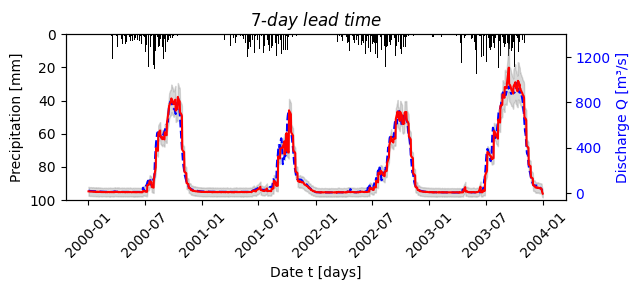

In [ ]:
# Create a date range from '01-01-2000' to '12-31-2005'
time1 = np.datetime64('2000-01-02')
time2 = np.datetime64('2003-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Configure the y-axis for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place the ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge values
ax2 = ax1.twinx()
ax2.plot(time, discharge[1:], 'b--', label='Qobs')

# Plot the minimum, maximum, and mean values as a confidence interval region
ax2.fill_between(time, train_uncertainty_df['lower_bound'], train_uncertainty_df['upper_bound'], color='gray', alpha=0.3, label='95% CrI')

# Plot the mean trajectory
ax2.plot(time, train_uncertainty_df['Q_mean'], 'r', label='Qsim')

# Configure the y-axis for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-60, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Display the grid
# plt.grid(True)

# Use tight_layout to prevent overlap
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("Q_hyM_save1.jpeg", format='jpeg', dpi=500)

# Download the file
# files.download("Q_hyM_save1.jpeg")

# Display the plot
plt.show()


In [ ]:
#Accuracy evaluation using the mean
nse_value = nash_sutcliffe_efficiency(discharge[1:], train_uncertainty_df['Q_mean'])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge[1:], train_uncertainty_df['Q_mean']))

print('kge=',kge(discharge[1:], train_uncertainty_df['Q_mean']))

Nash-Sutcliffe Efficiency (NSE): 0.9644028064451797
rmse= 50.88371667838735
kge= 0.9590804328408528


In [ ]:
#UQ evaluation with PICP and MPIW
observed = discharge[1:]
lower_bound = train_uncertainty_df['lower_bound']
upper_bound = train_uncertainty_df['upper_bound']

# Calculate the "hits" and "misses" for the Hit Rate (HR)
hits = np.sum((observed >= lower_bound) & (observed <= upper_bound))
misses = len(observed) - hits
hit_rate = (hits / (hits + misses)) * 100  # formula in percentage

# Calculate the Mean Prediction Interval Width (MPIW)
mpiw = np.mean(upper_bound - lower_bound)

print(f"PICP %: {hit_rate:}")
print(f"MPIW: {mpiw}")


PICP %: 88.76712328767124
MPIW: 104.87619018554688


VALIDATION

In [ ]:
#Multiple run
n_experiments = 10000

test_uncertainty_df = pd.DataFrame()


# Convert into 3D
scaled_test_X = torch.tensor(scaled_test_X, dtype=torch.float32).unsqueeze(1)

for i in range(n_experiments):
  experiment_predictions = bayesian_lstm.predict(scaled_test_X)
  test_uncertainty_df['Q_{}'.format(i)] = inverse_transform(experiment_predictions).flatten()

Q_df = test_uncertainty_df.filter(like='Q_', axis=1)
test_uncertainty_df['Q_mean'] = Q_df.mean(axis=1)
test_uncertainty_df['Q_std'] = Q_df.std(axis=1)

test_uncertainty_df = test_uncertainty_df[['Q_mean', 'Q_std']]

In [ ]:
#Build interval borns
test_uncertainty_df['lower_bound'] = test_uncertainty_df['Q_mean'] - 1.645*test_uncertainty_df['Q_std']
test_uncertainty_df['upper_bound'] = test_uncertainty_df['Q_mean'] + 1.645*test_uncertainty_df['Q_std']

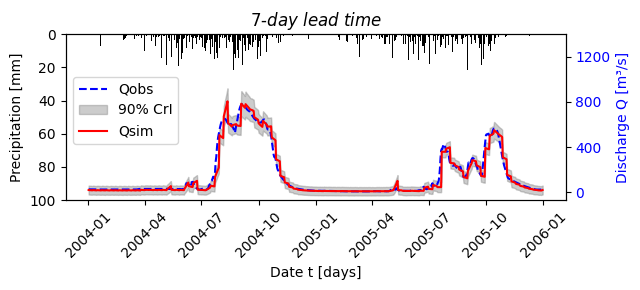

In [ ]:
# Create a date range from '01-01-2004' to '12-31-2005'
time1 = np.datetime64('2004-01-02')  # Start date
time2 = np.datetime64('2005-12-31')  # End date
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(6.5, 3.))

# Plot a histogram for precipitation on ax1
ax1.bar(time, prec1[1:], color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Configure the y-axis for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert the y-axis and place the ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge values
ax2 = ax1.twinx()
ax2.plot(time, discharge1[1:], 'b--', label='Qobs')

# Plot the minimum, maximum, and mean values as a confidence interval region
ax2.fill_between(time, test_uncertainty_df['lower_bound'], test_uncertainty_df['upper_bound'], color='gray', alpha=0.4, label='90% CrI')

# Plot the mean trajectory
ax2.plot(time, test_uncertainty_df['Q_mean'], 'r', label='Qsim')

# Configure the y-axis for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-70, 1400)
ax2.set_yticks(np.arange(0, 1400, 400))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.11, 0.75))

# Display the grid
# plt.grid(True)

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Use tight_layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
#Accuracy evaluation
nse_value = nash_sutcliffe_efficiency(discharge1[1:], test_uncertainty_df['Q_mean'])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], test_uncertainty_df['Q_mean']))

#print('r2=',calculate_r2(discharge1[1:], test_uncertainty_df['Q_mean']))

print('kge=',kge(discharge1[1:], test_uncertainty_df['Q_mean']))

Nash-Sutcliffe Efficiency (NSE): 0.9525610457590947
rmse= 47.040390506922115
kge= 0.9448243299531048


#### Evaluating Uncertainty

In [ ]:
#UQ evaluation with PICP and MPIW
observed = discharge1[1:]
lower_bound = test_uncertainty_df['lower_bound']
upper_bound = test_uncertainty_df['upper_bound']

# Calculate the "hits" and "misses" for the Hit Rate (HR)
hits = np.sum((observed >= lower_bound) & (observed <= upper_bound))
misses = len(observed) - hits
hit_rate = (hits / (hits + misses)) * 100  # HR formula in percentage

# Calculate the Mean Prediction Interval Width (MPIW)
mpiw = np.mean(upper_bound - lower_bound)

print(f"Hit Rate (HR) in %: {hit_rate:}")
print(f"Mean Prediction Interval Width (MPIW): {mpiw}")


Hit Rate (HR) in %: 88.76712328767124
Mean Prediction Interval Width (MPIW): 96.95926666259766


Scatter plot

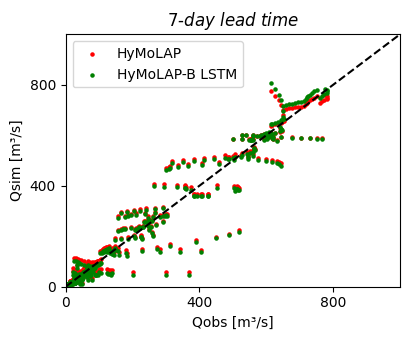

In [ ]:
# Scatter plot of observed (Qobs) vs simulated (Qsim) values
plt.figure(figsize=(4.2, 3.5))  # Set the figure size

# Scatter plots
plt.scatter(discharge1[1:], S71[1:], color='red', marker='.', s=20, label='HyMoLAP')
plt.scatter(discharge1[1:], test_uncertainty_df['Q_mean'], color='green', marker='.', s=20, label='HyMoLAP-B LSTM')

# Labels
plt.xlabel('Qobs [m³/s]')
plt.ylabel('Qsim [m³/s]')

# Adjust the x and y-axis limits
plt.xlim(0, 1000)
plt.ylim(0, 1000)

# Set x and y ticks with a step of 400
plt.xticks(range(0, 1001, 400))
plt.yticks(range(0, 1001, 400))

# Reference line (y = x)
plt.plot([0, 1000], [0, 1000], color='black', linestyle='--')

# Add the legend without a frame
plt.legend(loc='upper left')  # Remove the frame

# Add a title to the plot with LaTeX mathematical symbols
plt.title(r'$7$-$day$ $lead$ $time$')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


# Conclusions
- The hybrid approach has been able to produce similar performance compared to the HyMoLAP model in this sub-catchment
- The main goal of using the bayesian LSTM has been to effectively forecast uncertainty around point prediction
- Bayesian LSTMs have been able to produce comparable performance to their frequentist counterparts (all else being equal)
- Stochastic dropout enables users to approximate the posterior distribution of the target variable, \
and thus construct confidence intervals for each prediction